In [57]:
import functions
import importlib
from matplotlib import pyplot as plt
from PIL import Image
importlib.reload(functions)

<module 'functions' from 'c:\\Users\\ivoar\\Documents\\CDIA\\P8\\PDI\\PDI_Projeto_Final\\functions.py'>

In [54]:
imagens = functions.load_and_resize_images()
labels = functions.load_labels()
functions.convert_labels_to_yolo()

Conversão concluída! Labels salvos em 'data/labels_yolo'


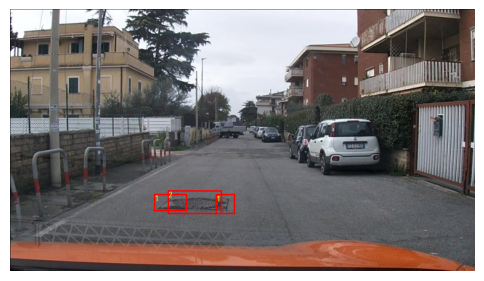

In [58]:
key = "vlcsnap-2025-02-26-20h40m08s649"  # exemplo
img = Image.open(f"data/images/{key}.jpg")
yolo_label = f"data/labels_yolo/{key}.txt"

functions.plot_yolo_bbox(img, yolo_label)


In [3]:
print(len(imagens), len(labels))

# Pega apenas as chaves que existem nos dois dicionários
common_keys = set(imagens.keys()) & set(labels.keys())

# Filtra os dicionários
imagens = {k: imagens[k] for k in common_keys}
labels = {k: labels[k] for k in common_keys}

print(len(imagens), len(labels))

1907 1907
1907 1907


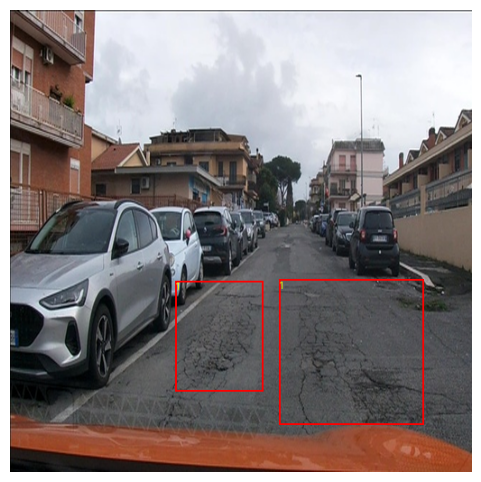

In [4]:
key = list(imagens.keys())[30]  
img = imagens[key]
label_text = labels.get(key, "")

functions.plot_image_with_polygons(img, label_text)

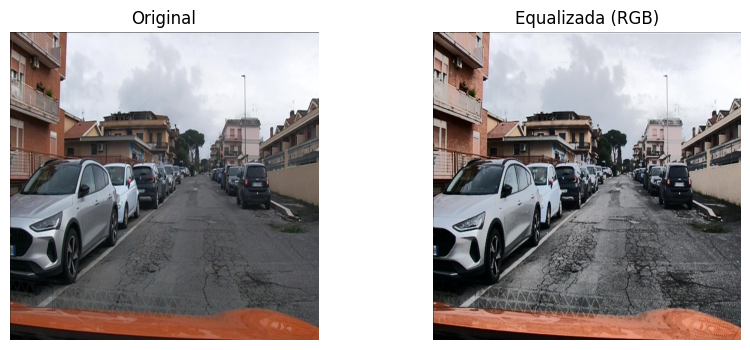

In [5]:
img = imagens[list(imagens.keys())[30]]  # pega uma imagem qualquer
img_eq = functions.equalize_image_rgb(img)


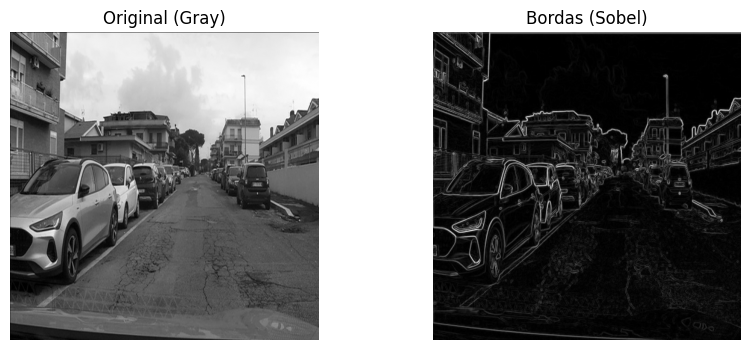

In [6]:
img = imagens[list(imagens.keys())[30]]  # pega uma imagem qualquer
edges_img = functions.sobel_edges(img)


In [2]:
import os
import shutil
import random

def split_dataset(images_folder='data/images', labels_folder='data/labels_yolo',
                  output_folder='dataset', train_ratio=0.7, val_ratio=0.2):
    
    os.makedirs(output_folder, exist_ok=True)
    for subset in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_folder, 'images', subset), exist_ok=True)
        os.makedirs(os.path.join(output_folder, 'labels', subset), exist_ok=True)

    all_files = [f for f in os.listdir(images_folder) if f.lower().endswith(('.jpg', '.png')) and 'vlcsnap' in f and not 'm' in f]
    random.shuffle(all_files)
    n_total = len(all_files)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)

    splits = {
        'train': all_files[:n_train],
        'val': all_files[n_train:n_train+n_val],
        'test': all_files[n_train+n_val:]
    }

    for subset, files in splits.items():
        for f in files:
            shutil.copy(os.path.join(images_folder, f), os.path.join(output_folder, 'images', subset, f))
            label_file = os.path.splitext(f)[0] + '.txt'
            shutil.copy(os.path.join(labels_folder, label_file),
                        os.path.join(output_folder, 'labels', subset, label_file))

    print("Divisão concluída: train/val/test")
split_dataset()


Divisão concluída: train/val/test


In [3]:
from ultralytics import YOLO

# Cria ou carrega modelo YOLOv8 pré-treinado (por exemplo, 'yolov8n.pt' para versão nano)
model = YOLO("yolov8n.pt")

# Treina
model.train(
    data="conf.yaml",
    epochs=50,
    imgsz=640,
    batch=8,
    project="yolo_asfalto",
    name="exp1",
    device="cpu"  # GPU se disponível, 0 = primeira GPU
)


Ultralytics 8.3.204  Python-3.11.9 torch-2.8.0+cpu CPU (11th Gen Intel Core i5-1135G7 @ 2.40GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=conf.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp13, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pr

KeyboardInterrupt: 

In [ ]:
# Predição em imagem
results = model.predict("dataset/images/test/vlcsnap123.jpg", conf=0.25)

# Plota resultado
results.show()


In [1]:
import cv2
import numpy as np

def sobel_combined_gray(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    # Sobel X e Y
    sx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    mag = np.sqrt(sx**2 + sy**2)
    mag = np.uint8(255 * (mag / np.max(mag)))
    return mag

img = cv2.imread("dataset/images/train/vlcsnap-00004.jpg")
edges = sobel_combined_gray(img)
cv2.imwrite("exemplo_sobel.png", edges)

True

In [2]:
def preprocess_clahe_denoise(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2,a,b))
    img_clahe = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
    # denoise bilateral (preserva bordas)
    den = cv2.bilateralFilter(img_clahe, d=9, sigmaColor=75, sigmaSpace=75)
    return den

proc = preprocess_clahe_denoise(img)
cv2.imwrite("exemplo_clahe_denoise.png", proc)


True

In [3]:
from skimage.feature import local_binary_pattern
import numpy as np

def lbp_features(gray, P=8, R=1):
    lbp = local_binary_pattern(gray, P, R, method="uniform")
    # histograma normalizado como vetor de características
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, P + 3),
                             range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
feat = lbp_features(gray)
print(feat.shape)  # vetor de características


(10,)
